In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_addons as tfa
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix
import seaborn as sns

from datetime import datetime

print(tf.__version__)
tf.config.list_physical_devices('GPU')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.9.1
1 Physical GPUs, 1 Logical GPUs


2022-11-19 20:55:24.084176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 20:55:24.088131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 20:55:24.088303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 20:55:24.088910: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
(ds_train, ds_test, ds_validation), ds_info = tfds.load(
    'eurosat/all',
    split=['train[:80%]','train[80%:90%]','train[90%:100%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [3]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['sparse_categorical_accuracy']
    val_accuracy = training_history.history['val_sparse_categorical_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.savefig(fname="resnet50V2/resnet50V2 history"+current_time,dpi=300)

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return image[:,:,1:4]/28002., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

ds_validation = ds_validation.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_validation = ds_validation.batch(128)
ds_validation = ds_validation.cache()

In [5]:
def preview_dataset(dataset):
    for image, label in dataset.take(20):
        print(image)
preview_dataset(ds_test)

tf.Tensor(
[[[[0.03942576 0.03339047 0.0292122 ]
   [0.03942576 0.03339047 0.0292122 ]
   [0.03685451 0.03239054 0.02531962]
   ...
   [0.03178344 0.0252482  0.01692736]
   [0.03214056 0.02656953 0.0167488 ]
   [0.03199771 0.0258553  0.01771302]]

  [[0.03942576 0.03339047 0.0292122 ]
   [0.03942576 0.03339047 0.0292122 ]
   [0.03685451 0.03239054 0.02531962]
   ...
   [0.03178344 0.0252482  0.01692736]
   [0.03214056 0.02656953 0.0167488 ]
   [0.03199771 0.0258553  0.01771302]]

  [[0.03524748 0.03017642 0.02285551]
   [0.03524748 0.03017642 0.02285551]
   [0.03949718 0.03481894 0.02806942]
   ...
   [0.03124777 0.02492679 0.01678452]
   [0.03156918 0.02578387 0.01678452]
   [0.03210485 0.02639097 0.01732019]]

  ...

  [[0.04796086 0.0496036  0.06313835]
   [0.04796086 0.0496036  0.06313835]
   [0.04788944 0.05163917 0.06613813]
   ...
   [0.04292551 0.04349689 0.05185344]
   [0.0438183  0.04331833 0.05185344]
   [0.04399686 0.0438183  0.05146061]]

  [[0.04963931 0.05281766 0.067102

tf.Tensor(
[[[[0.03239054 0.03060496 0.02471252]
   [0.03239054 0.03060496 0.02471252]
   [0.03153346 0.03024784 0.02321263]
   ...
   [0.04885365 0.04631812 0.04403257]
   [0.05278194 0.05031784 0.05431755]
   [0.07028069 0.07888722 0.08281551]]

  [[0.03239054 0.03060496 0.02471252]
   [0.03239054 0.03060496 0.02471252]
   [0.03153346 0.03024784 0.02321263]
   ...
   [0.04885365 0.04631812 0.04403257]
   [0.05278194 0.05031784 0.05431755]
   [0.07028069 0.07888722 0.08281551]]

  [[0.03246197 0.0310335  0.02599814]
   [0.03246197 0.0310335  0.02599814]
   [0.03160489 0.03031926 0.02442683]
   ...
   [0.05413899 0.0477823  0.04963931]
   [0.05946004 0.05910292 0.06220984]
   [0.07538747 0.07285194 0.08295836]]

  ...

  [[0.02817656 0.02714092 0.01660596]
   [0.02817656 0.02714092 0.01660596]
   [0.03099779 0.03096207 0.02185558]
   ...
   [0.03481894 0.03142633 0.02546247]
   [0.03849725 0.03449754 0.03028355]
   [0.04110421 0.03696164 0.03324762]]

  [[0.02924791 0.02728377 0.018177

2022-11-19 20:55:24.792796: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [6]:
#FLIP
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image
# AUGMENT COLOR
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.07)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_hue(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.062)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_saturation(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_saturation(image, lower=0.745, upper=1.25)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_brightness(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_brightness(image, 0.062)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_contrast(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_contrast(image, lower=0.85, upper=1.05)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
# ROTATE
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )
#INVERT
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.8:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [7]:
def augment_data(image,label):
  image=augment_flip(image)
  #image=augment_color(image)
  #image=augment_rotation(image)
  #image=augment_inversion(image)
  #image=augment_hue(image)
  image=augment_saturation(image)
  image=augment_brightness(image)
  image=augment_contrast(image)


  return image,label

In [8]:
ds_train_augmented = ds_train.map(augment_data)

In [9]:
resnet = tf.keras.applications.ResNet50V2(include_top = False,
                                          input_shape = (64,64,3),
                                          classes = 10)

model = tf.keras.models.Sequential(resnet)
model.add(tf.keras.layers.Dropout(0.875))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

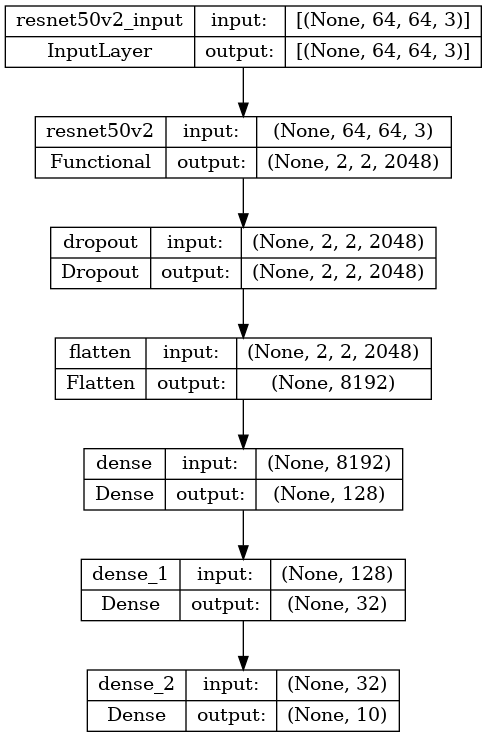

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [11]:
history = model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_validation,
    callbacks = tf.keras.callbacks.ModelCheckpoint(
        "resnet50V2/resnet50v2 epoch:{epoch:02d}-val_loss:{val_loss:.3f}",
        save_best_only = True,
        initial_value_threshold = 0.25
    )
)

Epoch 1/100


2022-11-19 20:55:30.575719: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-19 20:55:31.279116: W tensorflow/core/common_runtime/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


169/169 [==============================] - 27s 124ms/step - loss: 4.2604 - sparse_categorical_accuracy: 0.1178 - val_loss: 2.4528 - val_sparse_categorical_accuracy: 0.1333
Epoch 2/100
169/169 [==============================] - 19s 114ms/step - loss: 2.9500 - sparse_categorical_accuracy: 0.1718 - val_loss: 2.3763 - val_sparse_categorical_accuracy: 0.1478
Epoch 3/100
169/169 [==============================] - 19s 114ms/step - loss: 2.4178 - sparse_categorical_accuracy: 0.2276 - val_loss: 2.2854 - val_sparse_categorical_accuracy: 0.1807
Epoch 4/100
169/169 [==============================] - 20s 121ms/step - loss: 2.1408 - sparse_categorical_accuracy: 0.2700 - val_loss: 1.9870 - val_sparse_categorical_accuracy: 0.3874
Epoch 5/100
169/169 [==============================] - 21s 126ms/step - loss: 1.9199 - sparse_categorical_accuracy: 0.3275 - val_loss: 1.5930 - val_sparse_categorical_accuracy: 0.5315
Epoch 6/100
169/169 [==============================] - 23s 134ms/step - loss: 1.7241 - spars

169/169 [==============================] - 23s 138ms/step - loss: 0.0252 - sparse_categorical_accuracy: 0.9930 - val_loss: 0.3834 - val_sparse_categorical_accuracy: 0.9411
Epoch 46/100
169/169 [==============================] - 23s 138ms/step - loss: 0.0290 - sparse_categorical_accuracy: 0.9921 - val_loss: 0.4033 - val_sparse_categorical_accuracy: 0.9411
Epoch 47/100
169/169 [==============================] - 23s 138ms/step - loss: 0.0235 - sparse_categorical_accuracy: 0.9941 - val_loss: 0.3778 - val_sparse_categorical_accuracy: 0.9448
Epoch 48/100
169/169 [==============================] - 24s 139ms/step - loss: 0.0239 - sparse_categorical_accuracy: 0.9937 - val_loss: 0.3785 - val_sparse_categorical_accuracy: 0.9441
Epoch 49/100
169/169 [==============================] - 24s 141ms/step - loss: 0.0248 - sparse_categorical_accuracy: 0.9941 - val_loss: 0.3882 - val_sparse_categorical_accuracy: 0.9459
Epoch 50/100
169/169 [==============================] - 24s 140ms/step - loss: 0.0222 - 

169/169 [==============================] - 20s 115ms/step - loss: 0.0083 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.4977 - val_sparse_categorical_accuracy: 0.9407
Epoch 90/100
169/169 [==============================] - 20s 116ms/step - loss: 0.0055 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.5330 - val_sparse_categorical_accuracy: 0.9348
Epoch 91/100
169/169 [==============================] - 19s 115ms/step - loss: 0.0050 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.4900 - val_sparse_categorical_accuracy: 0.9396
Epoch 92/100
169/169 [==============================] - 20s 116ms/step - loss: 0.0069 - sparse_categorical_accuracy: 0.9983 - val_loss: 0.4693 - val_sparse_categorical_accuracy: 0.9400
Epoch 93/100
169/169 [==============================] - 20s 116ms/step - loss: 0.0058 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.5070 - val_sparse_categorical_accuracy: 0.9426
Epoch 94/100
169/169 [==============================] - 19s 115ms/step - loss: 0.0061 - 


Test accuracy: 0.9492592811584473


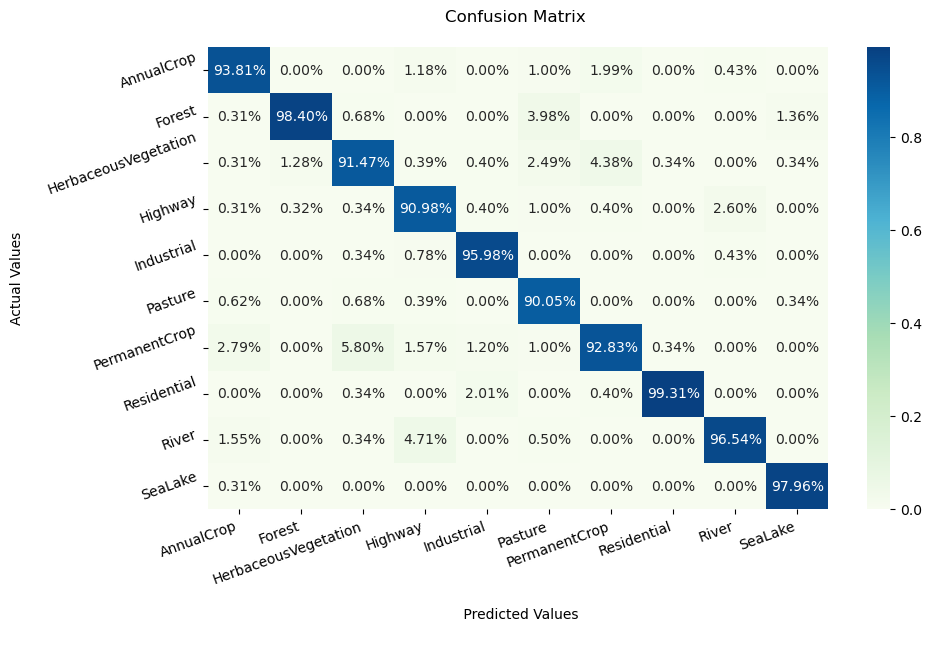

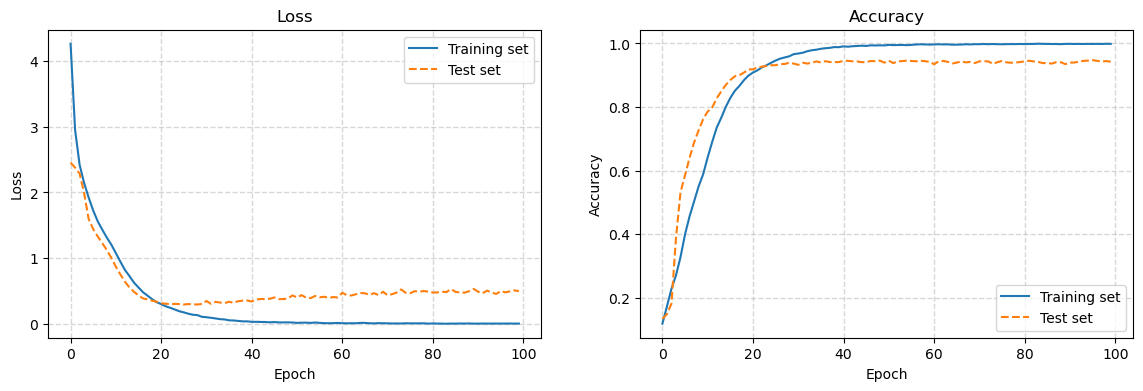

In [12]:
test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print('\nTest accuracy:', test_acc)


ds_test_predict = model.predict(ds_test, verbose=0)

labels_iterator = ds_test.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels = np.array(list(labels_iterator))

y_pred = np.argmax(ds_test_predict, axis=1)
y_test = labels
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_pred, y_test, normalize="pred"), annot=True, fmt=".2%",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")
fx.yaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
plt.savefig(fname="resnet50V2/resnet50V2 confusion matrix"+current_time,dpi=300)
render_training_history(history)
